<a href="https://colab.research.google.com/github/valeriylo/Med_img_analysis/blob/master/Practicum4_shape_models_Lobanov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is the last practical task of Sirius summer school "Applying AI for Med image analysis". 
Practical tasks take form of jupyter notebook with example code in the begging and some tasks in the end. Please, provide your solution in form of python code. Read hints, google a lot, don't hesitate to ask us directyl and most importatly - 
<span style="color:blue">have fun</span>.

**Topic**: Shape models 

**To submit**: New version of the notebook, with your code. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/My Drive/Sirius 2020/'

#### Important module imports

In [4]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import procrustes
import sklearn
from sklearn import decomposition
import glob
import os
from PIL import Image
import numpy as np
import re
%matplotlib inline 

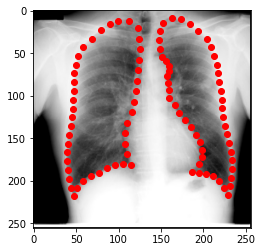

In [5]:
def parseFile(fileName):
    """
    Dark magic function to load points into dict
    """
    objects = {}
    pattern = re.compile("[-+]?\d*\.\d+|\d+")
    points = []
    currentName = ''
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        if '  [Label=' in line:
            if currentName != '':
                objects[currentName] = points
            points = []
            currentName = line[9:-2]
        if line[0:4] == '  { ':
            splitted = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            points.append([float(splitted[0]), float(splitted[1])])
    objects[currentName] = points
    return objects
        
def readBothLungFields(fileName, scaler = 4):
    objects = parseFile(fileName)
    lungs = np.concatenate((np.asarray(objects['right lung']),
                            np.asarray(objects['left lung']))) / scaler
    return lungs

def readCompleteDatabase(dataFolder):
    database = {}
    files = os.listdir(dataFolder + '/Images/' )
    for file in files:
        caseName = os.path.split(file)[-1][:-4]
        im = Image.open(dataFolder + '/Images/' + caseName + '.bmp')
        pIm = np.array(im)[:, :, 0]
        databaseElement = {}
        databaseElement['points'] = readBothLungFields(dataFolder+"/scratch/landmarks/"+caseName+".pfs")
        databaseElement['image'] = im
        database[caseName] = databaseElement
    return database

database = readCompleteDatabase(path + "data/Lung images from Bram/")
plt.scatter(database['JPCLN001']['points'][:, 0], database['JPCLN001']['points'][:, 1], c = 'r')
plt.imshow(database['JPCLN001']['image'], cmap='gray');

## **Task 1 Procrustes:**
- Normalize the scale, translation and rotation for the shape model before segmentation with active shape models. Do not forget to save scale factors in the database.
- Given: Database of lung shapes
- Do: fill in applyProcrustes function, which would normalize all shapes in database. . 


Hint https://stackoverflow.com/questions/18925181/procrustes-analysis-with-numpy

In [6]:
-database['JPCLN001']['points'][:, 1] # y
database['JPCLN001']['points'][:, 0]  # x

array([ 99.75   ,  89.40475,  79.0595 ,  68.71425,  58.369  ,  52.77375,
        49.9285 ,  48.     ,  47.     ,  47.     ,  46.75   ,  46.25   ,
        45.5    ,  43.75   ,  41.5    ,  40.25   ,  39.5    ,  39.25   ,
        39.96425,  42.     ,  44.     ,  47.5    ,  50.75   ,  57.8125 ,
        67.21875,  76.625  ,  86.03125,  95.4375 , 104.84375, 114.25   ,
       110.5    , 107.25   , 108.     , 110.5    , 115.5    , 117.75   ,
       120.     , 121.25   , 122.5    , 123.75   , 125.     , 124.5    ,
       122.5    , 112.15   , 173.5    , 183.72625, 193.9525 , 203.6785 ,
       209.     , 212.881  , 215.35725, 217.08325, 217.75   , 220.03575,
       221.25   , 221.488  , 223.     , 225.25   , 227.5    , 229.5    ,
       231.869  , 233.25   , 233.     , 232.25   , 231.75   , 229.25   ,
       224.25   , 218.83325, 211.25   , 203.16675, 195.08325, 187.     ,
       194.75   , 197.75   , 198.25   , 195.5    , 191.25   , 185.48075,
       178.51925, 170.75   , 166.     , 159.5    , 

In [7]:
def translation(database):
    centers_x = []
    centers_y = []

    for key in database.keys():
        centers_x.append(np.mean(database[key]['points'][:, 0]))
        centers_y.append(np.mean(database[key]['points'][:, 1]))

    mean_center_x = np.mean(centers_x)
    mean_center_y = np.mean(centers_y)

    for key in database.keys():
        database[key]['points'][:, 0] = database[key]['points'][:, 0] + (mean_center_x - np.mean(database[key]['points'][:, 0]))
        database[key]['points'][:, 1] = database[key]['points'][:, 1] + (mean_center_y - np.mean(database[key]['points'][:, 1]))

    return database, mean_center_x, mean_center_y

In [8]:
def scale(database, mean_center_x, mean_center_y):
    dists_x = []
    dists_y = []

    for key in database.keys():
        dist_x = np.sqrt(np.mean((database[key]['points'][:, 0] - mean_center_x) ** 2))
        dist_y = np.sqrt(np.mean((database[key]['points'][:, 1] - mean_center_y) ** 2))

        dists_x.append(dist_x)
        dists_y.append(dist_y)

    mean_dist_x = np.mean(dists_x)
    mean_dist_y = np.mean(dists_y)

    for key in database.keys():
        database[key]['points'][:, 0] = database[key]['points'][:, 0] / np.sqrt(np.mean(database[key]['points'][:, 0] ** 2)) * (mean_dist_x)
        database[key]['points'][:, 1] = database[key]['points'][:, 1] / np.sqrt(np.mean(database[key]['points'][:, 1] ** 2)) * (mean_dist_y)

    return database

In [9]:
def applyProcrustes(database):

    # translation
    # scale
    # rotation

    for i in range(40):
        database, mean_center_x, mean_center_y = translation(database)
        database = scale(database, mean_center_x, mean_center_y)

    return database

In [10]:
# rewrite original database
database = readCompleteDatabase(path + "data/Lung images from Bram/")

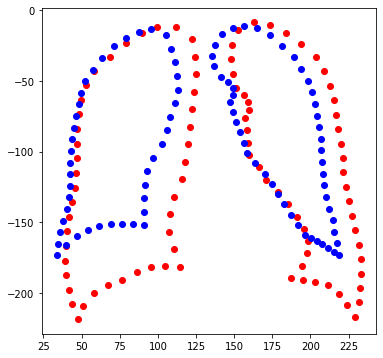

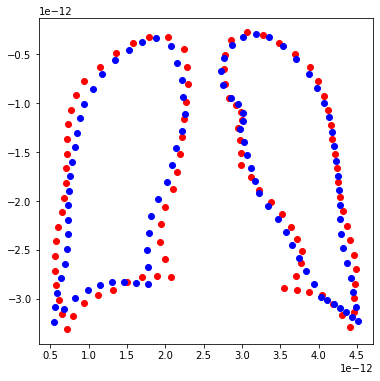

In [11]:
plt.figure(1, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b')
applyProcrustes(database)
plt.figure(2, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b');

# Principal component analysis

## **Task 2 PCA:**
- Compute PCA for lung shape and generate different lung field variaitons
- Given: Database of lung shapes and applyProcrustes function from previous step
- Do: fill in generatePCA function, which would generate pca decomposition of lung shapes. Visualize some of them, using provided function


Hint https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [12]:
# rewrite original database
database = readCompleteDatabase(path + "data/Lung images from Bram/")

In [13]:
from sklearn.decomposition import PCA

def generatePCA(database):
    lungs = []
    
    for key in database.keys():
        # lungs.append(np.concatenate([database[key]['points'][:, 0],  database[key]['points'][:, 1]]))
        lungs.append(np.concatenate([database[key]['points'][:, 1],  database[key]['points'][:, 0]]))

    lungs = np.array(lungs)
    
    #lungs.resize(lungs.shape[0], lungs.shape[1] * lungs.shape[2])
    print(lungs.shape)

    pca = PCA(n_components=lungs.shape[1])
    pca.fit(lungs)
  
    return pca

def visualizePCAComponents(database, pca):
    keys = list(database.keys())
    dataArray = np.zeros((len(keys), 2 * database[keys[0]]['points'].shape[0]))
    for i in range(len(keys)):
        dataArray[i, :] = database[keys[i]]['points'].flatten('F')
    meanShape = np.mean(dataArray, axis = 0)
    size = [[0, int(meanShape.shape[0] / 2)], [int(meanShape.shape[0] / 2), meanShape.shape[0]]]
    plt.figure(1)
    # print('variance = ', pca.explained_variance_)
    # print('explained_variance_ratio_ = ', pca.explained_variance_ratio_)
    # print('singular_values_ = ', pca.singular_values_)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey=True)

    axs[0][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'b')
    axs[0][0].title.set_text('first component -2 sigma')
    axs[0][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[0][1].title.set_text('mean')
    axs[0][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'g')
    axs[0][2].title.set_text('first component +2 sigma')
    
    
    axs[1][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'b')
    axs[1][0].title.set_text('second component -2 sigma')
    axs[1][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[1][1].title.set_text('mean')
    axs[1][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'g')
    axs[1][2].title.set_text('second component +2 sigma')
    
    axs[2][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'b')
    axs[2][0].title.set_text('third component -2 sigma')
    axs[2][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[2][1].title.set_text('mean')
    axs[2][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'g')
    axs[2][2].title.set_text('third component +2 sigma')
    
    return

(247, 188)


<Figure size 432x288 with 0 Axes>

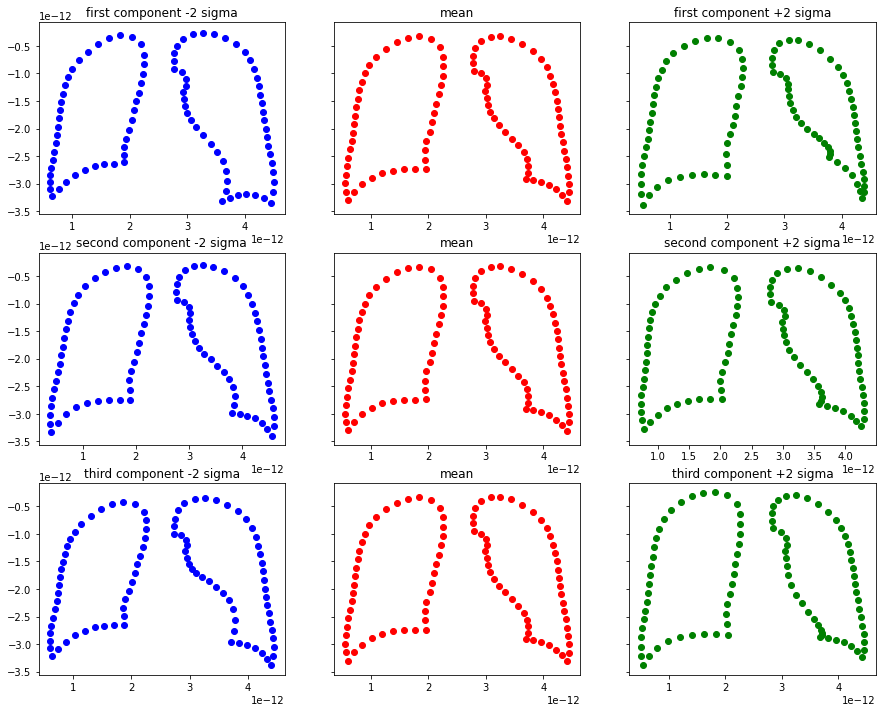

In [14]:
applyProcrustes(database)
pca = generatePCA(database)
visualizePCAComponents(database, pca)